<a href="https://colab.research.google.com/github/kangdoung/CS114.K21/blob/master/Do_an_cuoi_ky/Classify_face_celeb_svc_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bài toán nhận dạng người nổi tiếng**
* Input: ảnh của 1 trong 5 người  
* Output: tên người nổi tiếng của ảnh đó  
* Dataset gồm ảnh của 5 người: Amee, My Tam,Son Tung MTP, Jack và NDLN.  
Dữ liệu được thu thập từ google image sau đó được cắt và lấy khuôn mặt của mỗi người trên. Thu thập 100 tấm ảnh của mỗi người.  
Dataset được lưu trên google drive ( [*link*](/https://drive.google.com/drive/folders/1YjNGdPb_3equCM7M4tBaXYQpUN8AFIMd?usp=sharing)).


In [61]:
import numpy as np
import pandas as pd
import cv2 #open cv
import os
import matplotlib.pyplot as plt

# Load dữ liệu và gán label cho dữ liệu

## Tập TRAIN


In [148]:
# building an array of images and finding its shape.
Images_train = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder + '/' + filename
        #print(filename)
        img = cv2.imread(filename,0)
        img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
        Images_train.append(img)
Images_train = np.asarray(Images_train)
Images_train.shape

(400, 50, 50)

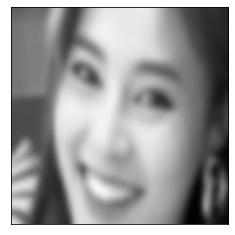

In [149]:
plt.imshow(Images_train[10], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([]) 
plt.show()

In [150]:
label_train = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder):
        label_train.append(imgfolder)
label_train = np.asarray(label_train)
label_train.shape

(400,)

## Tập TEST

In [151]:
# building an array of images and finding its shape.
Images_test = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder + '/' + filename
        #print(filename)
        img = cv2.imread(filename,0)
        img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
        Images_test.append(img)
Images_test = np.asarray(Images_test)
Images_test.shape

(100, 50, 50)

In [152]:
label_test = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder):
        label_test.append(imgfolder)
label_test = np.asarray(label_test)
label_test.shape

(100,)

### Khác

In [153]:
x_train = Images_train
x_test = Images_test
y_train = label_train
y_test = label_test

## Model


In [97]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

Thêm các thư viện cần thiết

In [154]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [155]:
#flatten images.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [115]:
from sklearn.model_selection import learning_curve, GridSearchCV

In [156]:
# doing cross validation to tune the params of SVC

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(x_train, y_train)
print(grid.best_params_)

CPU times: user 35.1 s, sys: 10.2 s, total: 45.3 s
Wall time: 23.3 s
{'svc__C': 1, 'svc__gamma': 0.005}


In [157]:
grid.best_score_

0.5625

In [159]:
model = grid.best_estimator_
pred = model.predict(x_test)

In [119]:
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report

In [160]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

        Amee       0.70      0.54      0.61        26
        Jack       0.85      0.85      0.85        20
         MTP       0.65      0.68      0.67        19
       MyTam       0.45      0.75      0.56        12
        NDLN       0.60      0.52      0.56        23

    accuracy                           0.65       100
   macro avg       0.65      0.67      0.65       100
weighted avg       0.67      0.65      0.65       100



In [161]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred, y_test))

[[14  2  2  4  4]
 [ 1 17  2  0  0]
 [ 1  0 13  2  3]
 [ 1  0  1  9  1]
 [ 3  1  2  5 12]]


In [162]:
accuracy_score(pred, y_test)

0.65

### Nhận xét:
model cho kết quả dự đoán khá thấp do chỉ sử dụng PCA để trích chọn đặc trưng.

# Thử nghiệm bộ dữ liệu với CNN



In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import keras
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [163]:
image_size = 50
def read_date(path):
  img = []
  label = []
  folders = os.listdir(path)
  for folder in os.listdir(path):
    i = 1
    for files in os.listdir(path+'/'+folder):
      files_name = path + '/'+folder+'/' + files
      
      print(files_name)
      print('STT: {}'.format(i))
      i += 1
      image = cv2.imread(files_name,0)
      
      image = cv2.resize(image, (image_size, image_size))
      images=np.reshape(image, image_size*image_size)
      img.append(images)
      label.append(folder)

  return np.asarray(img),np.asarray(label)

train_path = 'drive/My Drive/data_cnn/Train'
x_train, y_train = read_date(train_path)

test_path = 'drive/My Drive/data_cnn/Test'
x_test, y_test = read_date(test_path)

val_path = 'drive/My Drive/data_cnn/Validation'
x_val, y_val = read_date(val_path)

Streaming output truncated to the last 5000 lines.
STT: 333
drive/My Drive/data_cnn/Train/MyTam/MyTam27__rot90.jpg
STT: 334
drive/My Drive/data_cnn/Train/MyTam/MyTam21__rot90.jpg
STT: 335
drive/My Drive/data_cnn/Train/MyTam/MyTam56__rot90.jpg
STT: 336
drive/My Drive/data_cnn/Train/MyTam/MyTam29__rot-90.jpg
STT: 337
drive/My Drive/data_cnn/Train/MyTam/MyTam25__rot-90.jpg
STT: 338
drive/My Drive/data_cnn/Train/MyTam/MyTam40__rot90.jpg
STT: 339
drive/My Drive/data_cnn/Train/MyTam/MyTam50__rot90.jpg
STT: 340
drive/My Drive/data_cnn/Train/MyTam/MyTam46__rot-90.jpg
STT: 341
drive/My Drive/data_cnn/Train/MyTam/MyTam23__rot90.jpg
STT: 342
drive/My Drive/data_cnn/Train/MyTam/MyTam51__rot-90.jpg
STT: 343
drive/My Drive/data_cnn/Train/MyTam/MyTam33__rot-90.jpg
STT: 344
drive/My Drive/data_cnn/Train/MyTam/MyTam44__rot90.jpg
STT: 345
drive/My Drive/data_cnn/Train/MyTam/MyTam26__rot90.jpg
STT: 346
drive/My Drive/data_cnn/Train/MyTam/MyTam21__rot-90.jpg
STT: 347
drive/My Drive/data_cnn/Train/MyTam/My

In [164]:
x_train.shape

(3280, 2500)

In [165]:
y_train.shape

(3280,)

In [166]:
y_val.shape

(720,)

## Data Augmentation

In [167]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_train = labelencoder_X.fit_transform(y_train)
y_test = labelencoder_X.transform(y_test)
y_val = labelencoder_X.transform(y_val)


In [168]:
x_train = x_train.reshape(x_train.shape[0], 50, 50, 1)
x_val = x_val.reshape(x_val.shape[0], 50, 50, 1)
x_test = x_test.reshape(x_test.shape[0], 50, 50, 1)

In [169]:
y_train = np_utils.to_categorical(y_train, 5)
y_val = np_utils.to_categorical(y_val, 5)
y_test = np_utils.to_categorical(y_test, 5)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',y_train[0])

Dữ liệu y ban đầu  [1. 0. 0. 0. 0.]
Dữ liệu y sau one-hot encoding  [1. 0. 0. 0. 0.]


## Xây dựng model

In [170]:
num_classes = 5

In [175]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape = (50,50,1), activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = num_classes, activation = 'softmax'))

In [172]:
opt = keras.optimizers.Adam(learning_rate=0.0005)

In [176]:
model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [178]:
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          batch_size=328, epochs=90, verbose=1)

Train on 3280 samples, validate on 720 samples
Epoch 1/90
3280/3280 [==============================] - 2s 514us/step - loss: 0.0640 - accuracy: 0.9826 - val_loss: 1.2128 - val_accuracy: 0.6611
Epoch 2/90
3280/3280 [==============================] - 2s 487us/step - loss: 0.0542 - accuracy: 0.9872 - val_loss: 1.1085 - val_accuracy: 0.6736
Epoch 3/90
3280/3280 [==============================] - 2s 485us/step - loss: 0.0526 - accuracy: 0.9863 - val_loss: 1.1778 - val_accuracy: 0.6819
Epoch 4/90
3280/3280 [==============================] - 2s 484us/step - loss: 0.0560 - accuracy: 0.9845 - val_loss: 1.2072 - val_accuracy: 0.6750
Epoch 5/90
3280/3280 [==============================] - 2s 483us/step - loss: 0.0545 - accuracy: 0.9857 - val_loss: 1.1853 - val_accuracy: 0.6792
Epoch 6/90
3280/3280 [==============================] - 2s 486us/step - loss: 0.0515 - accuracy: 0.9872 - val_loss: 1.2143 - val_accuracy: 0.6764
Epoch 7/90
3280/3280 [==============================] - 2s 482us/step - loss:

In [179]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(x_test, y_test)
print(score)

800/800 [==============================] - 0s 417us/step
[1.7355349445343018, 0.6700000166893005]


In [180]:
model.save('drive/My Drive/data_cnn/cnn_model')

### Dự đoán ảnh

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6.jpg to ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6 (1).jpg


In [ ]:
from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
Images_pred = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  filename = fn
  img = cv2.imread(filename,0)
  img = cv2.resize(img, (80,80), interpolation = cv2.INTER_AREA)
  Images_pred.append(img)
Images_pred = np.asarray(Images_pred)
Images_pred.shape

User uploaded file "ninh-duong-lan-ngoc-bat-trend-len-ca-cay-do-hoa-tiet-sau-gian-cach-ly-22a84cb6.jpg" with length 43279 bytes


(1, 80, 80)

Giá trị dự đoán:  2


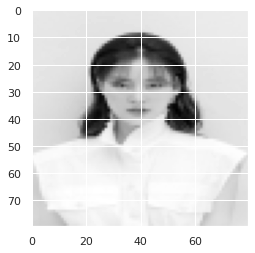

In [ ]:
plt.imshow(Images_pred[0].reshape(80,80), cmap='gray')

Predict = model.predict(Images_pred.reshape(1,80,80,1))
print('Giá trị dự đoán: ', np.argmax(Predict))